In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import nltk
import string
import tensorflow_hub as hub
import tensorflow as tf

# Import libraries & data 

In [30]:
X = pd.read_csv("D:/kaggle_datasets/nlp-getting-started/train.csv")
X_test = pd.read_csv("D:/kaggle_datasets/nlp-getting-started/test.csv")
submission = pd.read_csv("D:/kaggle_datasets/nlp-getting-started/sample_submission.csv")
y = X["target"]

In [31]:
X

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [32]:
X = X["text"]

In [33]:
X[:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

## Delete noise

In [34]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
X = pd.Series(map(clean_text, X))

In [35]:
X[:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
dtype: object

# Tokenize

In [36]:
X = [nltk.word_tokenize(sentence) for sentence in X]

In [37]:
pd.DataFrame(X[:5])

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,our,deeds,are,the,reason,of,this,earthquake,may,allah,...,all,None,None,None,None,None,None,None,None,None
1,forest,fire,near,la,ronge,sask,canada,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,all,residents,asked,to,shelter,in,place,are,being,notified,...,no,other,evacuation,or,shelter,in,place,orders,are,expected
3,people,receive,wildfires,evacuation,orders,in,california,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,just,got,sent,this,photo,from,ruby,alaska,as,smoke,...,pours,into,a,school,None,None,None,None,None,None


## Delete stopwords

In [38]:
nltk.corpus.stopwords.words('english')[:5]

['i', 'me', 'my', 'myself', 'we']

In [39]:
def remove_stopwords(text):
    words = [w for w in text if w not in nltk.corpus.stopwords.words('english')]
    return words

X = list(map(remove_stopwords, X))

In [40]:
pd.DataFrame(X[:5])

,0,1,2,3,4,5,6,7,8,9,10
0,deeds,reason,earthquake,may,allah,forgive,us,None,None,None,None
1,forest,fire,near,la,ronge,sask,canada,None,None,None,None
2,residents,asked,shelter,place,notified,officers,evacuation,shelter,place,orders,expected
3,people,receive,wildfires,evacuation,orders,california,None,None,None,None,None
4,got,sent,photo,ruby,alaska,smoke,wildfires,pours,school,None,None


# Tensorflow hub Word2vec

In [13]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")
embeddings = embed(["cat is on the mat", "dog is in the fog"])

In [382]:
np.array(embed(X[0]))

array([[-0.08799809, -0.0858438 ,  0.10788755, ...,  0.04565184,
         0.01294351, -0.01602245],
       [-0.06259975, -0.01230032,  0.07308406, ...,  0.03657548,
         0.03782785,  0.02362303],
       [-0.08326939, -0.05621659,  0.03247604, ...,  0.02686087,
        -0.06714934, -0.03165756],
       ...,
       [-0.09174909,  0.06146185, -0.00974257, ..., -0.02225812,
        -0.08056538,  0.00302481],
       [-0.1161094 , -0.00886208,  0.10882459, ...,  0.04372574,
        -0.01066343,  0.01358622],
       [-0.1149641 , -0.02637827,  0.07625245, ...,  0.03208056,
        -0.04156599, -0.03963792]], dtype=float32)

In [391]:
np.array(embed(X[0])).shape

(7, 250)

In [396]:
np.concatenate((np.array(embed(X[0])), np.array(embed(X[0]))), axis=0).shape

(14, 250)

In [330]:
embeddings.numpy().shape

(2, 250)

In [331]:
for i in range(len(X)):
    X[i] = embed(X[i]).numpy()

In [337]:
X = np.array(X)

C:\Users\hjhhi\AppData\Local\Temp\ipykernel_12104\55319187.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


# Integer encoding

In [167]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [168]:
pd.DataFrame(X[:5])

,0,1,2,3,4,5,6,7,8,9,10
0,4164,724,143,53,1512,4165,12.0,NaN,NaN,NaN,NaN
1,95,4,125,579,6288,6289,1188.0,NaN,NaN,NaN,NaN
2,1513,1391,1881,530,6290,1514,149.0,1881.0,530.0,1189.0,911.0
3,8,4166,1190,149,1189,23,NaN,NaN,NaN,NaN,NaN
4,20,1021,228,6291,1882,156,1190.0,6292.0,96.0,NaN,NaN


In [169]:
tokenizer.word_index

{'like': 1,
 'amp': 2,
 'im': 3,
 'fire': 4,
 'get': 5,
 'new': 6,
 'via': 7,
 'people': 8,
 'one': 9,
 'dont': 10,
 'news': 11,
 'us': 12,
 'video': 13,
 'emergency': 14,
 'disaster': 15,
 'police': 16,
 'would': 17,
 'still': 18,
 'body': 19,
 'got': 20,
 'burning': 21,
 'back': 22,
 'california': 23,
 'crash': 24,
 'suicide': 25,
 'storm': 26,
 'time': 27,
 'know': 28,
 'man': 29,
 'day': 30,
 'first': 31,
 'buildings': 32,
 'rt': 33,
 'going': 34,
 'bomb': 35,
 'cant': 36,
 'world': 37,
 'see': 38,
 'nuclear': 39,
 'fires': 40,
 'love': 41,
 'youtube': 42,
 'attack': 43,
 'two': 44,
 'killed': 45,
 'go': 46,
 'dead': 47,
 'train': 48,
 'full': 49,
 'car': 50,
 'war': 51,
 'families': 52,
 'may': 53,
 'accident': 54,
 'good': 55,
 'today': 56,
 'hiroshima': 57,
 'think': 58,
 'life': 59,
 'many': 60,
 'say': 61,
 'watch': 62,
 'last': 63,
 'could': 64,
 'u': 65,
 'na': 66,
 'years': 67,
 'want': 68,
 'make': 69,
 'way': 70,
 'collapse': 71,
 'home': 72,
 'work': 73,
 'look': 74,
 'n

Average langth of tweet: 8.932221200577958


(array([2.160e+02, 6.370e+02, 1.172e+03, 2.213e+03, 1.472e+03, 1.160e+03,
        6.730e+02, 6.200e+01, 6.000e+00, 2.000e+00]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

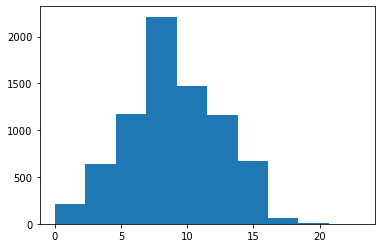

In [170]:
print("Average langth of tweet:", sum(map(len, X))/len(X))
plt.hist([len(tweet) for tweet in X])

Text(0.5, 1.0, 'Fake')

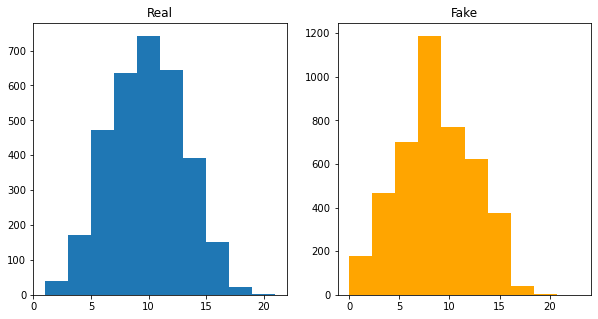

In [171]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.hist([len(X[i]) for i in range(len(X)) if y[i]==1])
ax1.set_title("Real")
ax2.hist([len(X[i]) for i in range(len(X)) if y[i]==0], color="orange")
ax2.set_title("Fake")

In [172]:
count=0
for tweet in X:
    if len(tweet) > 20:
        count+=1
print((len(X)-count) / len(X))

0.9997372914751084


In [173]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=20, padding="post")

In [174]:
def preprocess(text_sequence):
    text_sequence = pd.Series(map(clean_text, text_sequence))    
    text_sequence = [nltk.word_tokenize(sentence) for sentence in text_sequence]
    text_sequence = list(map(remove_stopwords, text_sequence))    
    text_sequence =  tokenizer.texts_to_sequences(text_sequence)
    text_sequence = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=20, padding="post") 
    return text_sequence

# Model tuning  
이전의 모델이 1번의 LSTM 반복, 100개의 은닉상태, 30epoch를 사용하였으므로 이를 똑같이 사용하여 성능 비교

In [44]:
X.dtype

AttributeError: 'list' object has no attribute 'dtype'

In [45]:
X, y = tf.ragged.constant(X),tf.ragged.constant(y)

In [52]:
X.shape

TensorShape([7613, None])

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([7285, 2553, 2494, ..., 5380, 4356, 1941], dtype=int64)

In [21]:
type(X_train[0][0])

str

In [25]:
def make_model(iter = 1, hidden=100):
#     Input = keras.Input(shape=[None,250])
    Input = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250/2", output_shape=[None, 250], dtype=tf.string)

#     x = keras.layers.Reshape((20, 1))(Input)
    
    for _ in range(iter):
        x = keras.layers.LSTM(hidden, return_sequences=True)(Input)
        
    x = keras.layers.LSTM(hidden)(x)
    x = keras.layers.Dense((hidden+40)/2, activation="relu")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=Input, outputs=output)
    model.compile(loss="binary_crossentropy", metrics="accuracy", optimizer="adam")
    return model

In [406]:
X_train.shape

(5709,)

In [353]:
X_train[0].dtype

dtype('float32')

In [53]:
model = make_model(1, 100)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30)

TypeError: Inputs to a layer should be tensors. Got: <tensorflow_hub.keras_layer.KerasLayer object at 0x00000251F81B77F0>

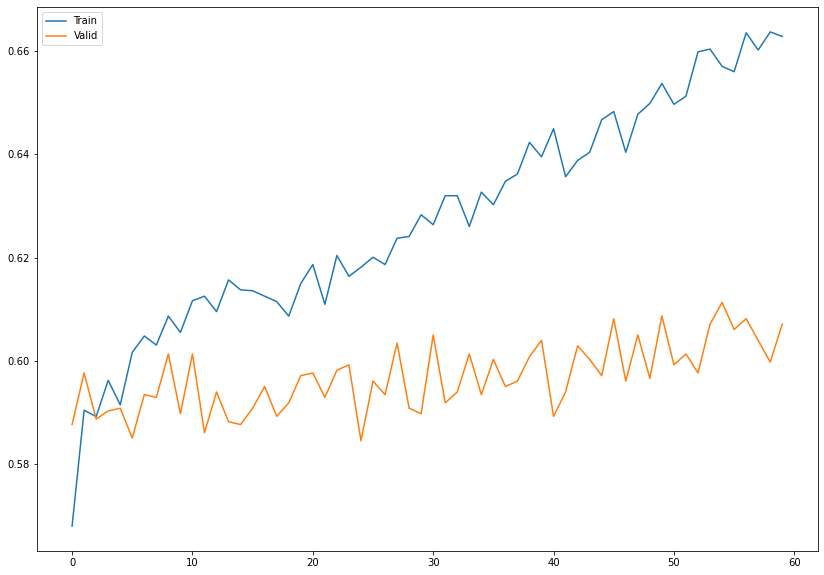

In [178]:
plt.figure(figsize=(14, 10))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Valid")
plt.legend()

In [179]:
model.evaluate(X_valid, y_valid)

60/60 [==============================] - 0s 6ms/step - loss: 0.6809 - accuracy: 0.6071


[0.6809261441230774, 0.6071428656578064]

In [127]:
model = make_model(1, 100)
model.fit(X,y, epochs=30)

Epoch 1/30
238/238 [==============================] - 5s 8ms/step - loss: 0.6770 - accuracy: 0.5661
Epoch 2/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6683 - accuracy: 0.5898
Epoch 3/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6641 - accuracy: 0.5978
Epoch 4/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6639 - accuracy: 0.6000
Epoch 5/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6607 - accuracy: 0.6042
Epoch 6/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6590 - accuracy: 0.6082
Epoch 7/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6596 - accuracy: 0.6066
Epoch 8/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6612 - accuracy: 0.6067
Epoch 9/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6599 - accuracy: 0.6020
Epoch 10/30
238/238 [==============================] - 2s 7ms/step - loss: 0.6579 - accuracy: 0.6050

In [151]:
history.history["val_accuracy"][-5:]

[0.6003151535987854,
 0.6239495873451233,
 0.6160714030265808,
 0.6171218752861023,
 0.605567216873169]

In [128]:
X_test = preprocess(X_test["text"])

In [129]:
submission["target"] = (model.predict(X_test)>0.5).astype("int32")

In [130]:
submission.to_csv("./rnn_with_preprocess.csv", index=None)

In [132]:
submission["target"].value_counts()

0    2559
1     704
Name: target, dtype: int64